<a href="https://colab.research.google.com/github/hmata84/hmata84/blob/main/311_System_Complaints_PredictionModel_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

#### The people of New Yorker use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

#### In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency. Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

#### The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their questions:

<br> __1. Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?__

<br> __2. Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?__

<br> __3. Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?__

<br> __4. Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1?__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium


## Importing the dataset

In [98]:
import zipfile
!unzip /content/311_Service_Requests_from_2010_to_Present_min.zip

Archive:  /content/311_Service_Requests_from_2010_to_Present_min.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/311_Service_Requests_from_2010_to_Present_min.zip or
        /content/311_Service_Requests_from_2010_to_Present_min.zip.zip, and cannot find /content/311_Service_Requests_from_2010_to_Present_min.zip.ZIP, period.


In [99]:
# Import the CSV file that containt the DB
df = pd.read_csv('/content/311_Service_Requests_from_2010_to_Present_min.csv')
df.drop("Unnamed: 0", axis= 1, inplace = True)
df.head()

FileNotFoundError: ignored

# Exploration of the Data

In [ ]:
# Checking the type of data in the dataframe.
df.info()

In [ ]:
#Checking is there are missing values
df.isna().sum()


  #### We have several observations on the Data:
  1. Closed Date attribute has the most missing values, but it is due to the open complaints.
  2. We can drop the rows without address since they won't be functional for our analysis and the other rows with missing values except Closed Date. 
  3. We also can drop the column `Unnamed`
  4. We must convert Dates from object to datetime format
  

In [ ]:
## Obs. #2. Drop the rows without address since they won't be functional for our analysis.
df.drop("Unnamed: 0", axis= 1, inplace = True)
df.dropna(subset = ["Incident Address", "Street Name", "Incident Zip", "Address Type", 'City', 'Resolution Description', 'Latitude', 'Longitude'], inplace = True)
print(df.isna().sum())
print('Total dropped rows:', (np.array([6019843,16]) - np.array([df.shape])))

In [ ]:
#convert "Created Date" and "Closed Date" to time.
df[["Created Date", "Closed Date"]] = df[["Created Date", "Closed Date"]].astype('datetime64[ns]')
df.info()

## Upload csv file with the dates converted to datetime

In [ ]:
#Upload a File to Cloud Object Store by Using the Credential and Bucket Variables
df.to_csv('311_System_Complaits_transformed.csv')

## 1. Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

#### We start with data exporation to understand it better.

In [3]:
import zipfile
!unzip /content/311_System_Complaits_transformed.zip

Archive:  /content/311_System_Complaits_transformed.zip
  inflating: 311_System_Complaits_transformed.csv  


In [4]:
df_new = pd.read_csv('/content/311_System_Complaits_transformed.csv')
df_new.drop("Unnamed: 0", axis= 1, inplace = True)
df_new.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Street Name,Address Type,City,Status,Resolution Description,Borough,Latitude,Longitude
0,45531130,2020-02-02 06:09:17,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10019.0,426 WEST 52 STREET,WEST 52 STREET,ADDRESS,NEW YORK,Open,The following complaint conditions are still o...,MANHATTAN,40.765132,-73.988993
1,45529784,2020-02-02 14:15:24,NaN,UNSANITARY CONDITION,RESIDENTIAL BUILDING,11204.0,1751 67 STREET,67 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.618484,-73.992673
2,45527528,2020-02-02 02:27:41,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,11372.0,87-15 37 AVENUE,37 AVENUE,ADDRESS,Jackson Heights,Open,The following complaint conditions are still o...,QUEENS,40.750269,-73.879432
3,45530329,2020-02-02 12:13:18,NaN,HEAT/HOT WATER,RESIDENTIAL BUILDING,10458.0,2405 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,Open,The following complaint conditions are still o...,BRONX,40.853773,-73.881558
4,45528814,2020-02-02 13:59:44,NaN,APPLIANCE,RESIDENTIAL BUILDING,11209.0,223 78 STREET,78 STREET,ADDRESS,BROOKLYN,Open,The following complaint conditions are still o...,BROOKLYN,40.629745,-74.030533


### Indentify th oldest and the most recent entrance.

In [5]:
# Sort dataframe
df_new.sort_values(by = ['Created Date'], inplace =True)
print("Oldest Entrance", df_new['Created Date'].head(1))
print("Most Recent Entrance", df_new['Created Date'].tail(1))

Oldest Entrance 171360    2010-01-01 00:00:00
Name: Created Date, dtype: object
Most Recent Entrance 633    2020-02-02 23:58:57
Name: Created Date, dtype: object


### Identify number of Incident Address in the df

In [6]:
#Number of Incidents Address in the DB
print("The number of Incident Address are:", df_new["Incident Address"].nunique())

The number of Incident Address are: 181675


#### Import PLUTO Bronx dataset that gives geography features 

In [7]:
import zipfile
!unzip /content/nyc_pluto_18v1.zip

Archive:  /content/nyc_pluto_18v1.zip
  inflating: PLUTO_for_WEB/BK_18v1.csv  
  inflating: PLUTO_for_WEB/BX_18v1.csv  
  inflating: PLUTO_for_WEB/MN_18v1.csv  
  inflating: PLUTO_for_WEB/PLUTODD18v1.pdf  
  inflating: PLUTO_for_WEB/PlutoReadme18v1.pdf  
  inflating: PLUTO_for_WEB/QN_18v1.csv  
  inflating: PLUTO_for_WEB/SI_18v1.csv  


In [8]:
#Importing PLUTO BX DB
bx = pd.read_csv('/content/PLUTO_for_WEB/BX_18v1.csv')
print("Dataframe size:", bx.shape)
bx.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,20,22,23,64,65,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataframe size: (89854, 87)


,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCenterDistrict,HealthArea,SanitBoro,SanitDistrict,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,...,UnitsTotal,LotFront,LotDepth,BldgFront,BldgDepth,Ext,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptLand,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLAG,PFIRM15_FLAG,Version
0,BX,2260,1,201,19.0,1022.0,7.0,8.0,10454.0,L029,40.0,23.0,4700.0,2.0,1.0,2A,122 BRUCKNER BOULEVARD,M1-5/R8A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,Z9,NaN,0,NaN,122 BRUCKNER PARTNERS,15000,0,0,0,0,0,0,...,0,75.00,200.0,0.0,0.0,NaN,0.0,N,3.0,0.0,130500,161100,0,0,0,0,0,NaN,NaN,0.00,6.02,5.0,6.5,2,2022600001,0,19,1005957.0,232162.0,6b,NaN,209S016,20901.0,E-143,0.0,NaN,1,NaN,NaN,18V1
1,BX,2260,4,201,19.0,1022.0,7.0,8.0,10454.0,L029,40.0,23.0,4700.0,2.0,1.0,2A,126 BRUCKNER BOULEVARD,M1-5/R8A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,G5,7.0,0,NaN,24 INDIAN HEAD HOLDIN,13770,752,752,0,272,0,0,...,1,137.58,100.0,16.0,16.0,NaN,0.0,N,5.0,0.0,117000,326700,0,0,1931,1994,0,NaN,NaN,0.05,6.02,5.0,6.5,2,2022600004,0,19,1006076.0,232156.0,6b,NaN,209S016,20901.0,E-143,0.0,NaN,1,NaN,NaN,18V1
2,BX,2260,10,201,19.0,1022.0,7.0,8.0,10454.0,L029,40.0,23.0,4700.0,2.0,1.0,2A,138 BRUCKNER BOULEVARD,M1-5/R8A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,F5,6.0,0,P,ANJOST CORP,35000,39375,39375,0,0,0,0,...,1,175.00,200.0,175.0,200.0,NaN,0.0,N,4.0,0.0,153000,879300,0,0,1931,0,0,NaN,NaN,1.13,6.02,5.0,6.5,2,2022600010,0,19,1006187.0,232036.0,6b,NaN,209S016,20901.0,E-143,0.0,NaN,1,NaN,NaN,18V1
3,BX,2260,17,201,19.0,1022.0,7.0,8.0,10454.0,L029,40.0,23.0,4700.0,2.0,1.0,2A,144 BRUCKNER BOULEVARD,M1-5/R8A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,C1,2.0,0,NaN,144 BRUCKNER LLC,2500,12500,0,12500,0,0,0,...,15,25.00,100.0,25.0,85.0,NaN,0.0,N,5.0,0.0,51300,332550,0,0,1931,2001,0,NaN,NaN,5.00,6.02,5.0,6.5,2,2022600017,0,19,1006299.0,232033.0,6b,NaN,209S016,20901.0,E-143,0.0,NaN,1,NaN,NaN,18V1
4,BX,2260,18,201,19.0,1022.0,7.0,8.0,10454.0,L029,40.0,23.0,4700.0,2.0,1.0,2A,148 BRUCKNER BOULEVARD,M1-5/R8A,NaN,NaN,NaN,NaN,NaN,MX-1,NaN,NaN,NaN,N,C7,2.0,0,P,148 BRUCKNER LLC,1875,8595,1719,6876,0,1719,0,...,10,25.00,75.0,25.0,70.0,NaN,0.0,N,3.0,2.0,17490,125304,0,52349,1920,2009,0,NaN,NaN,4.58,6.02,5.0,6.5,2,2022600018,0,19,1006363.0,232040.0,6b,NaN,209S016,20901.0,E-143,0.0,NaN,1,NaN,NaN,18V1


In [9]:
#Number of ZipCodes in PLUTO Bronx DB
bx["ZipCode"].nunique()

26

According to 311 NYC Compalint System Data report, Heat/Hot Water & Heating are the same type of complaints. So we can merge both type of complaints.

In [10]:
#Merging 'HEATING','HEAT/HOT WATER'
df_new['Complaint Type'] = np.where(df_new['Complaint Type']=='HEATING','HEAT/HOT WATER',df_new['Complaint Type'])

In [11]:
#Number of different complaint types exist in the DB
print("Number of complaints that exist in the dataframe:",df_new["Complaint Type"].nunique())
#List of complaints names:
print("List of Complaint type:")
df_new["Complaint Type"].value_counts()

Number of complaints that exist in the dataframe: 20
List of Complaint type:


HEAT/HOT WATER          2130193
PLUMBING                 709026
GENERAL CONSTRUCTION     498637
UNSANITARY CONDITION     451218
PAINT - PLASTER          359690
PAINT/PLASTER            346155
ELECTRIC                 306411
NONCONST                 259956
DOOR/WINDOW              205126
WATER LEAK               193462
GENERAL                  151167
FLOORING/STAIRS          137311
APPLIANCE                112652
SAFETY                    51493
OUTSIDE BUILDING           7132
ELEVATOR                   6720
CONSTRUCTION               5031
STRUCTURAL                   16
AGENCY                        8
VACANT APARTMENT              6
Name: Complaint Type, dtype: int64

Below we made a bar plot to visualize how many complaint type are in the datasets and what is the top complaint type.

<Figure size 1296x864 with 0 Axes>

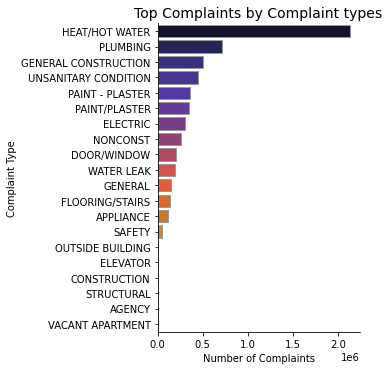

In [12]:
# bar plot.
plt.figure(figsize = (18,12))
sns.catplot(y = 'Complaint Type', kind = 'count',  palette = 'CMRmap', edgecolor = '0.6', data = df_new[['Complaint Type']], order = df_new['Complaint Type'].value_counts().index)
plt.title('Top Complaints by Complaint types', fontsize = 14 )
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.show()

## We also can explore if the top type of incident is related to an specific address. For that we need to plot the incidents in a map.

In [13]:
#Create a dataframe for the map
df_map = df_new[['Complaint Type', 'Latitude', 'Longitude']].loc[df_new["Complaint Type"].isin(["HEAT/HOT WATER"])]
df_map.reset_index(drop = True, inplace = True)
df_map.dropna(inplace = True)
df_map.isna().sum()

Complaint Type    0
Latitude          0
Longitude         0
dtype: int64

In [14]:
# get a random sample of 500 incidents in the df_map dataframe to reduce memory usage
n = 500
df_map = df_map.sample(n)

In [15]:
# create map of the NYC and display it
latitude = 40.730610
longitude = -73.935242
NY_map = folium.Map(location=[latitude, longitude], zoom_start=8, tiles='OpenStreetMap')

# instantiate a feature group for the incidents in the dataframe
comp = folium.map.FeatureGroup()

# loop through the incident location add each one to feature group 
for lat, lng, label in zip(df_map.Latitude, df_map.Longitude, df_map['Complaint Type']):
    comp.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='red',
            fill=True,
            popup = str(label),
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add buildings to map

NY_map.add_child(comp)


We can conclude that all the Hot/Heat Water complaints types are spread all over the Bronx and not to an specific area.

# Answer to Question 1:
#### - Heat/Hot Water and Plumbing are the top type of complaints, so the Agency should give priority to address them first, because of the high number.

### We indeified the top complaint types, but let's figure out if there is a relationship between complaints

In [16]:
# Building a correlation heatmap can help us to visualize correlation between complaint types.
# But first we have to encode the Complaint Types because is a categorical variable
complaints = df_new[['Unique Key','Complaint Type', 'Created Date']] 
complaints = pd.get_dummies(complaints, columns = ['Complaint Type'])
print(complaints.shape)
complaints.head()


(5931410, 22)


,Unique Key,Created Date,Complaint Type_AGENCY,Complaint Type_APPLIANCE,Complaint Type_CONSTRUCTION,Complaint Type_DOOR/WINDOW,Complaint Type_ELECTRIC,Complaint Type_ELEVATOR,Complaint Type_FLOORING/STAIRS,Complaint Type_GENERAL,Complaint Type_GENERAL CONSTRUCTION,Complaint Type_HEAT/HOT WATER,Complaint Type_NONCONST,Complaint Type_OUTSIDE BUILDING,Complaint Type_PAINT - PLASTER,Complaint Type_PAINT/PLASTER,Complaint Type_PLUMBING,Complaint Type_SAFETY,Complaint Type_STRUCTURAL,Complaint Type_UNSANITARY CONDITION,Complaint Type_VACANT APARTMENT,Complaint Type_WATER LEAK
171360,15636429,2010-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
171018,15635591,2010-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
171017,15635590,2010-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
171016,15635589,2010-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
171015,15635586,2010-01-01 00:00:00,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


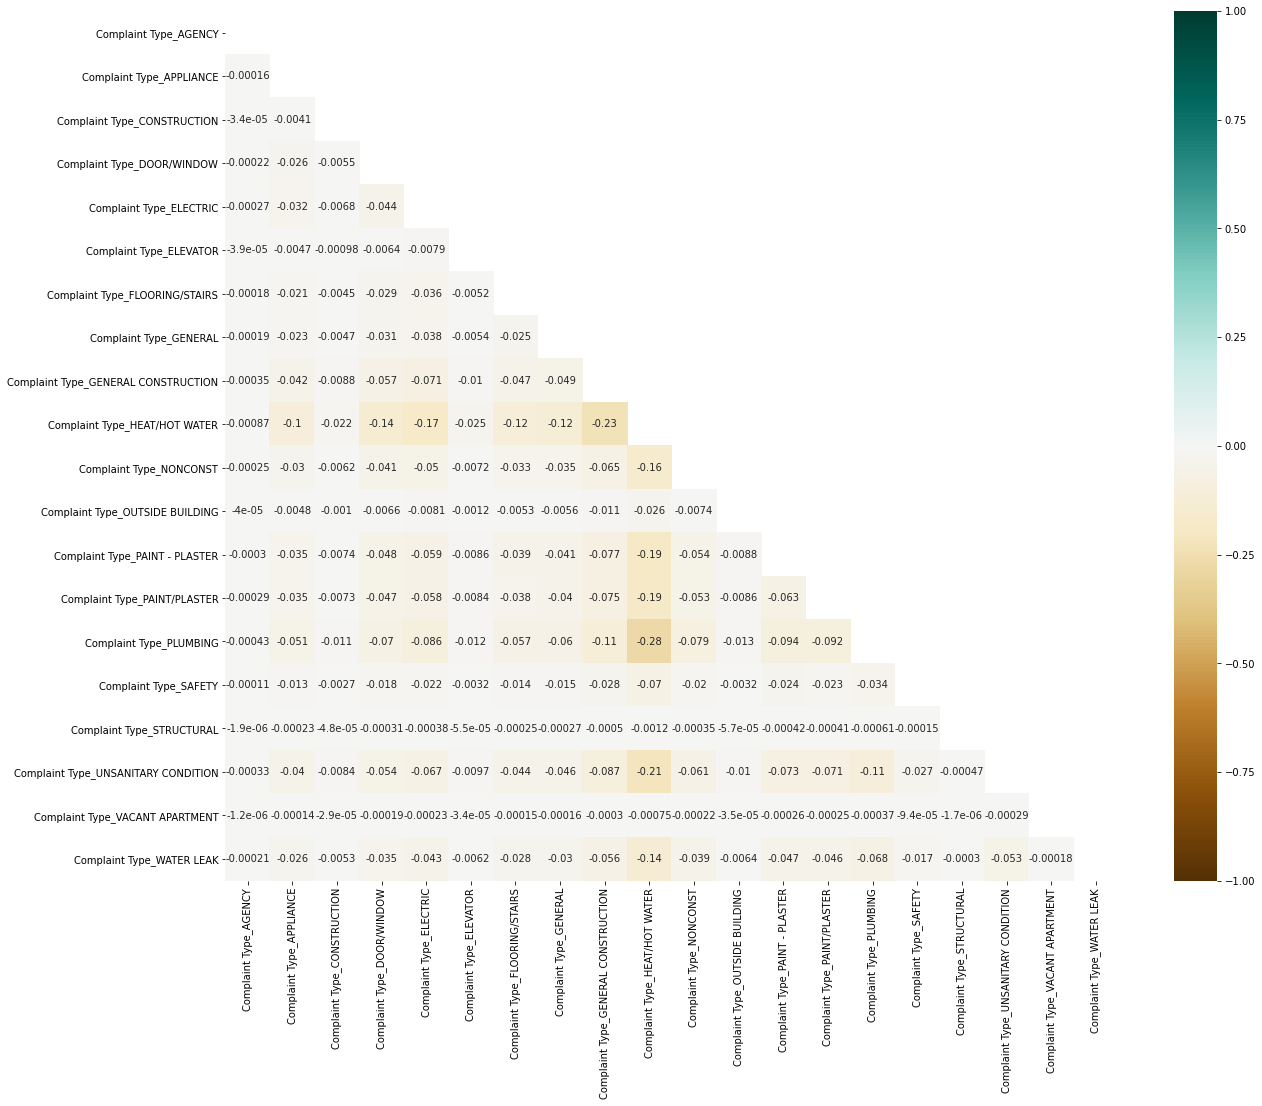

In [17]:
#Building the correlation heatmap
corr = complaints.iloc[:,2:]

plt.figure(figsize = (20,16))

mask = np.triu(np.ones_like(corr.corr(), dtype=np.bool))
sns.heatmap(corr.corr(), vmin = -1, vmax = 1, annot = True, cmap='BrBG', mask=mask )

### We see from the correlation heat map that only a few complaints are low correlated. max = 0.28

## 2. Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

In [18]:
#Borough that had the highest and the lowest number of complaints submitted based on HEAT/HOT WATER", "HEATING"
bourough = df_new.loc[df_new["Complaint Type"].isin(["HEAT/HOT WATER", "PLUMBING"])]
bourough["Borough"].value_counts()

BRONX            779476
BROOKLYN         772839
MANHATTAN        529412
Unspecified      414839
QUEENS           312041
STATEN ISLAND     30612
Name: Borough, dtype: int64

We can see BRONX has the most complaints for Heat/Hot Water and Heating

In [19]:
#which ZIP code had the highest number of complainted submitted
bourough[["Incident Zip"]].value_counts()


Incident Zip
11226.0         97569
10467.0         85695
10458.0         84583
10453.0         77498
10468.0         75738
                ...  
10112.0             1
10106.0             1
10103.0             1
10045.0             1
12345.0             1
Length: 194, dtype: int64

In [20]:
#which Address had the highest number of complainted submitted
bourough[["Incident Address"]].value_counts()

Incident Address     
34 ARDEN STREET          13724
89-21 ELMHURST AVENUE    11506
3810 BAILEY AVENUE        7111
1025 BOYNTON AVENUE       6052
9511 SHORE ROAD           4989
                         ...  
2790 GOULDEN AVENUE          1
279 YORK AVENUE              1
279 WEST  146 STREET         1
279 WEED AVENUE              1
1 1 AVENUE                   1
Length: 152275, dtype: int64

In [21]:
#how many of the submitted tickets were closed?
bourough[["Status"]].value_counts()

Status 
Closed     2797664
Open         41553
Pending          2
dtype: int64

## 3. Does the Complaint Type that you identified in response to question 1 have an obvious relationship with any particular characteristic or characteristics of the houses or buildings?

### In order to identify relationship between the top complaint and any particular characteristic we have to merge the complaints df_new with the PLUTO Bronx df to explore more features. Is call it `df_bx`

#### But before merge let's reduce the size of both dataframes by dropping useless columns.

In [22]:
bx = bx[["Address", "BldgArea", "BldgDepth", "BuiltFAR", "CommFAR", "FacilFAR", "Lot", "LotArea", "LotDepth",
               "NumBldgs", "NumFloors", "OfficeArea", "ResArea", "ResidFAR", "RetailArea", "YearBuilt", "YearAlter1", 
               "ZipCode"]]
df_new = df_new[['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type', 'Location Type', 'Incident Zip', 'Incident Address', 'Latitude', 'Longitude']]

In [23]:
#Merging dataframes using `left join` to preserve data of houses of the bx dataframe
df_bx = pd.merge(df_new, bx, left_on= 'Incident Address', right_on= 'Address', how = 'right', )
df_bx.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Latitude,Longitude,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122 BRUCKNER BOULEVARD,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0.0,0,0,6.02,0,0,0,10454.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126 BRUCKNER BOULEVARD,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,0,6.02,0,1931,1994,10454.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138 BRUCKNER BOULEVARD,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,0,0,6.02,0,1931,0,10454.0
3,32683899.0,2016-02-14 14:14:06,2016-02-18 18:42:11,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0
4,35207705.0,2017-01-09 09:59:21,2017-01-16 02:14:22,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0


Unique Key          66954
Created Date        66954
Closed Date         97490
Complaint Type      66954
Location Type       66954
Incident Zip        66954
Incident Address    66954
Latitude            66954
Longitude           66954
Address                69
BldgArea                0
BldgDepth               0
BuiltFAR                0
CommFAR                 0
FacilFAR                0
Lot                     0
LotArea                 0
LotDepth                0
NumBldgs                0
NumFloors               0
OfficeArea              0
ResArea                 0
ResidFAR                0
RetailArea              0
YearBuilt               0
YearAlter1              0
ZipCode               329
dtype: int64


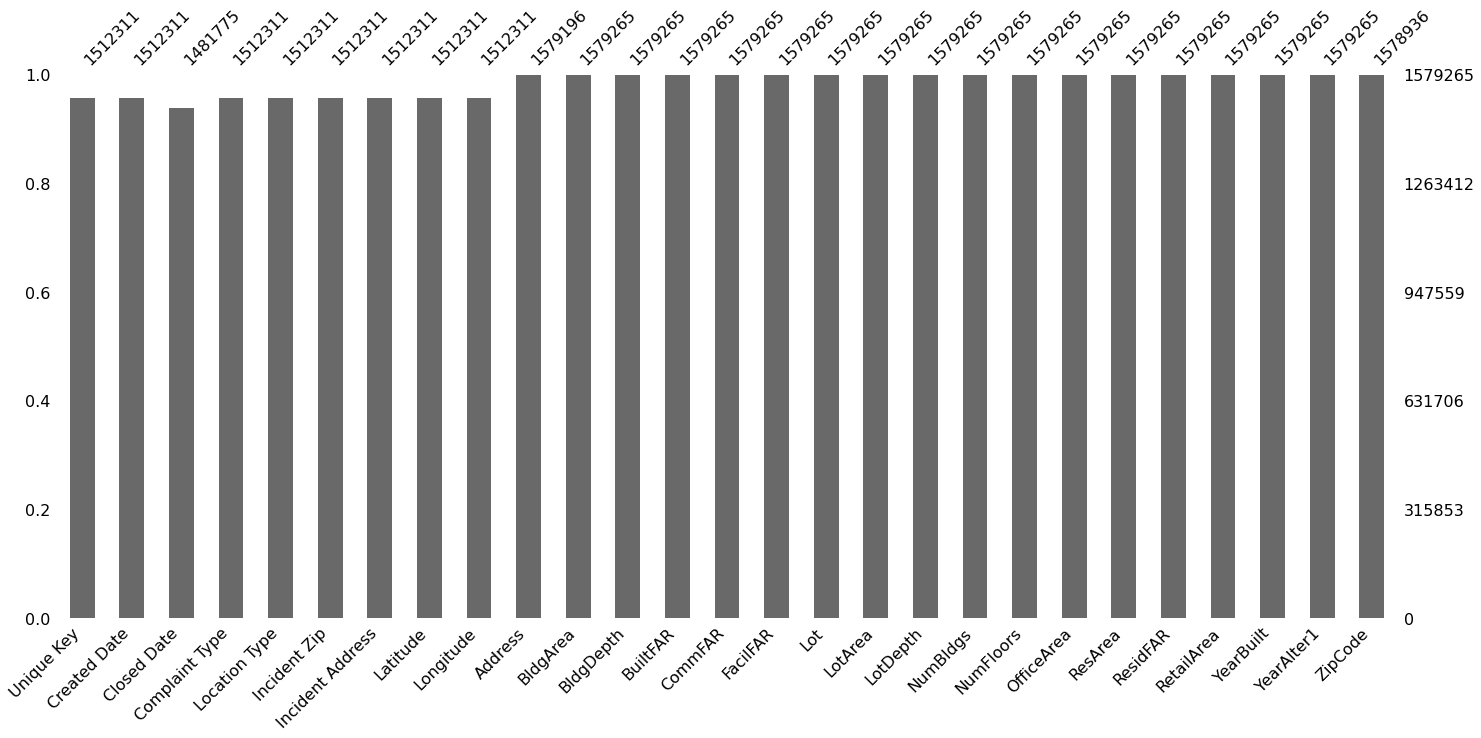

In [24]:
#Import library the help us to check the missing values
import missingno as msno
# Checking for missing values
print(df_bx.isnull().sum())

#Bar plot with missing values
msno.bar(df_bx)

#### We can see most of the missing values came from the merge of the two dataframes and most of then are from the dataframe `df_new`

#### Now we will proceed to drop the NaN values since most of them are in the `Complaint Type` column with is one of the important attributes of the dataset.

In [25]:
# Dropping missing values
df_bx.dropna(inplace = True)
# Validating missing values were dropped
print(df_bx.isnull().sum())

Unique Key          0
Created Date        0
Closed Date         0
Complaint Type      0
Location Type       0
Incident Zip        0
Incident Address    0
Latitude            0
Longitude           0
Address             0
BldgArea            0
BldgDepth           0
BuiltFAR            0
CommFAR             0
FacilFAR            0
Lot                 0
LotArea             0
LotDepth            0
NumBldgs            0
NumFloors           0
OfficeArea          0
ResArea             0
ResidFAR            0
RetailArea          0
YearBuilt           0
YearAlter1          0
ZipCode             0
dtype: int64


#### Now we validated we dropped the missing values, we created a new variable calculating building age.

In [26]:
#Create a new column with the building age.
df_bx["Bldg_Age"] = np.where(df_bx["YearBuilt"].any() > 0, (2021 - df_bx["YearBuilt"]), 0)

df_bx.head(2)
        

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Latitude,Longitude,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,Bldg_Age
3,32683899.0,2016-02-14 14:14:06,2016-02-18 18:42:11,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90
4,35207705.0,2017-01-09 09:59:21,2017-01-16 02:14:22,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90


In [27]:
#chequing unique values in building age column
df_bx['Bldg_Age'].unique()

array([  90,  101,   96,   21,  115,   20,  121,  112,  106,  100,   76,
        116,   23,   28,  114,   60,  111,   19,  120,   51,   49,   45,
         29,   61,   69,   17,   27,  103,   16,   15,   35,   89,   47,
         98,   38,   46,  117,  118,  119,    4,  122,   48,   18,    8,
         31,   30,   52,  133,  134,   14,   13,   11, 2021,   91,   63,
          9,   56,  135,   66,   71,  107,   10,   32,   94,    7,   55,
         74,  108,    5,   93,   97,   12,  109,   92,   58,  110,   99,
         86,  221,   26,  105,   22,   73,   44,   95,   83,   81,   53,
         41,    6,  104,   80,   50,  113,   85,   84,   82,   70,   79,
         67,   72,  102,   62,   68,   59,   64,   24,   25,   36,   39,
         40,   34,   33,   78,   65,   77,   57,   88,   54,  130,   37,
        132,   75,   43,   42,   87,  124])

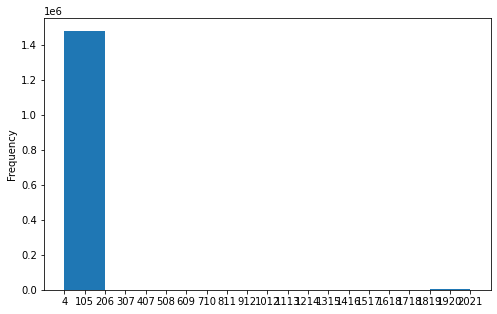

In [28]:
#We also can use a plot for better visualization
matrix = df_bx['Bldg_Age'].unique()
bins = int((max(matrix)-min(matrix))/(df_bx['Bldg_Age'].nunique()))
count, bin_edges = np.histogram(df_bx['Bldg_Age'], 20)
df_bx['Bldg_Age'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
                            

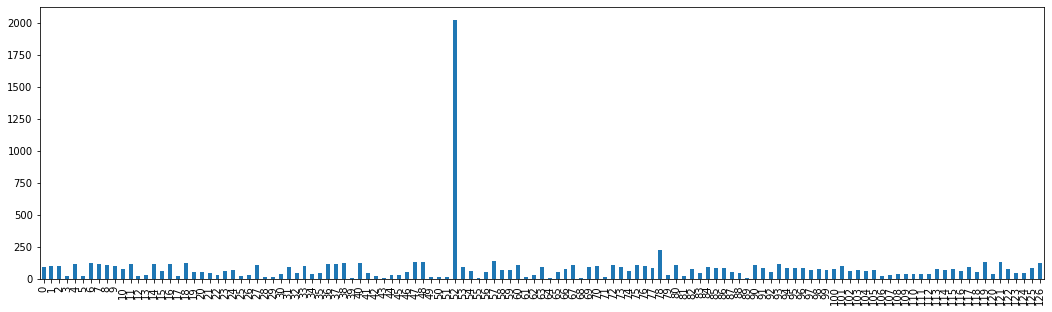

In [29]:
bars = pd.DataFrame(df_bx['Bldg_Age'].unique())
bars.plot(use_index = True, y = 0, kind='bar', figsize=(18, 5), legend = False)

We can observe from the above matrix and the plots there is a building age equal to 2021. We must drop it because is not logic. It cam from the calculation of the age.

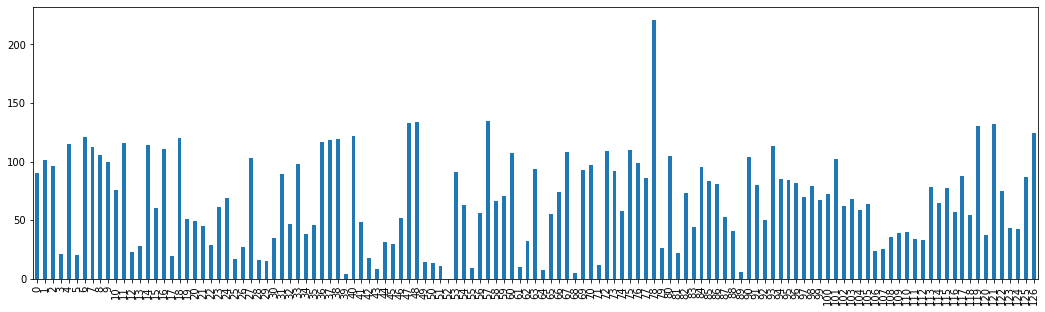

In [30]:
# Replace Age = 2021
df_bx["Bldg_Age"].replace(2021, 0, inplace = True)
bars = pd.DataFrame(df_bx['Bldg_Age'].unique())
bars.plot(use_index = True, y = 0, kind='bar', figsize=(18, 5), legend = False)

### Now we calculate the building age and solve incosistencies on the data. We proceed to create a DataFrame to work with the top complaint as per client request.

## Creating a new data frame with the top complaint identified in Question 1, HEAT/HOT WATER.


In [31]:
#Create two dataframes to work with the two highest complaint types.

df_heat = df_bx.loc[df_bx["Complaint Type"].isin(["HEAT/HOT WATER"])]
df_heat.reset_index(drop = True, inplace = True)


In [32]:
#Convert Complaint Type to number.
df_heat['Complaint Type'].replace({'HEAT/HOT WATER':1}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [33]:
# Create a new dataframe to find out correlation between complaint number and the different variables
df_comp = df_heat.groupby('Incident Address').agg('count')['Complaint Type'].to_frame()
df_comp.columns = ['Complaints #']

print('New Dataset: {} rows'.format(df_comp.shape[0]))
df_comp.head()

New Dataset: 18682 rows


,Complaints #
Incident Address,
1 CAROLL STREET,18
1 DOROTHEA PLACE,1
1 EAST 198 STREET,52
1 WEST TREMONT AVENUE,2
10 CLINTON PLACE,2


In [34]:
#Now merge df_comp with df_heat using righ join
df_comp2 = pd.merge(df_heat, df_comp, left_on= 'Incident Address', right_on= 'Incident Address', how = 'left', )
df_comp2.head()

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Latitude,Longitude,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,Bldg_Age,Complaints #
0,32683899.0,2016-02-14 14:14:06,2016-02-18 18:42:11,1,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90,5
1,35207705.0,2017-01-09 09:59:21,2017-01-16 02:14:22,1,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90,5
2,45190069.0,2019-12-18 02:51:53,2019-12-19 16:55:02,1,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90,5
3,45288422.0,2020-01-01 15:33:03,2020-01-03 17:00:03,1,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90,5
4,45413734.0,2020-01-17 13:01:25,2020-01-21 21:06:47,1,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90,5


In [35]:
# After merge dataframes, we check if there are NaN
df_comp2.isnull().sum()

Unique Key          0
Created Date        0
Closed Date         0
Complaint Type      0
Location Type       0
Incident Zip        0
Incident Address    0
Latitude            0
Longitude           0
Address             0
BldgArea            0
BldgDepth           0
BuiltFAR            0
CommFAR             0
FacilFAR            0
Lot                 0
LotArea             0
LotDepth            0
NumBldgs            0
NumFloors           0
OfficeArea          0
ResArea             0
ResidFAR            0
RetailArea          0
YearBuilt           0
YearAlter1          0
ZipCode             0
Bldg_Age            0
Complaints #        0
dtype: int64

We can see there are not NaN in the dataframe as expected becasue both dataframe have the same origin.

The dataframe has 553,240 entries, we have to check if there are duplicates address and then delete them.

In [36]:
df_comp2["Incident Address"].value_counts()

3810 BAILEY AVENUE         7091
1025 BOYNTON AVENUE        5783
888 GRAND CONCOURSE        3245
2968 PERRY AVENUE          2979
2074 WALLACE AVENUE        2711
                           ... 
1353 CLAY AVENUE              1
1159 SOUTHERN BOULEVARD       1
2322 HOLLAND AVENUE           1
711 EAST GUN HILL ROAD        1
738 CALHOUN AVENUE            1
Name: Incident Address, Length: 18682, dtype: int64

Now we found there are duplicate addresses we proceed to delete them because they are associsted with the same type of complaint..

In [37]:
df_comp2.drop_duplicates(subset = 'Incident Address', keep = 'first', inplace = True)

print('df_comp2 Dataset: Duplicate addresses dropped successfully!')
print('New df_comp2 Dataset: {} rows x {} columns'.format(df_comp2.shape[0], df_comp2.shape[1]))

df_comp2 Dataset: Duplicate addresses dropped successfully!
New df_comp2 Dataset: 18682 rows x 29 columns


On the next step, we reduce the data frame to work with only numerical variable to explore the relationship they have with the number of complaints.

In [38]:
# Checking the type of variable we have on the dataframe
df_comp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18682 entries, 0 to 553237
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unique Key        18682 non-null  float64
 1   Created Date      18682 non-null  object 
 2   Closed Date       18682 non-null  object 
 3   Complaint Type    18682 non-null  int64  
 4   Location Type     18682 non-null  object 
 5   Incident Zip      18682 non-null  float64
 6   Incident Address  18682 non-null  object 
 7   Latitude          18682 non-null  float64
 8   Longitude         18682 non-null  float64
 9   Address           18682 non-null  object 
 10  BldgArea          18682 non-null  int64  
 11  BldgDepth         18682 non-null  float64
 12  BuiltFAR          18682 non-null  float64
 13  CommFAR           18682 non-null  float64
 14  FacilFAR          18682 non-null  float64
 15  Lot               18682 non-null  int64  
 16  LotArea           18682 non-null  int64

In [39]:
# Get name of columns to  faacilitate the selection of the ones we are going to use.
df_comp2.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Complaint Type',
       'Location Type', 'Incident Zip', 'Incident Address', 'Latitude',
       'Longitude', 'Address', 'BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'ZipCode', 'Bldg_Age', 'Complaints #'],
      dtype='object')

Dataframe with only important numerical values, we exluded `Unique Key`, `Created Date`, `Closed Date` , `Incident Zip`, `Latitude`, `Longitude`  because their high cardinality.

In [40]:
# Dataframe with only important numerical values, we exlude Unique Key, 
df_comp2 = df_comp2[['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR',
       'FacilFAR', 'Lot', 'LotArea', 'LotDepth', 'NumBldgs', 'NumFloors',
       'OfficeArea', 'ResArea', 'ResidFAR', 'RetailArea', 'YearBuilt',
       'YearAlter1', 'Bldg_Age', 'Complaints #', 'Latitude', 'Longitude']]
df_comp2.shape

(18682, 20)

Now we created a correlation heatmap using Person method by default to check relationship between independent variables and the dependent variable `Complaint #`, which is the one we want to predict.

In [41]:
corr_p = df_comp2.corr()['Complaints #'].sort_values(ascending = False)

display(corr_p.to_frame().style.background_gradient(cmap = 'Reds', axis = 0))


,Complaints #
Complaints #,1.000000
NumFloors,0.266192
BldgDepth,0.215334
BuiltFAR,0.174990
ResidFAR,0.163719
ResArea,0.156009
FacilFAR,0.146168
BldgArea,0.138501
LotDepth,0.080663
YearAlter1,0.067025


We observed only a few variables have weak positive linear correlation using Pearson method with the Complaint # with a correlation Coeff ~ 0.27, `NumFloors` and `BldgDepth`

Nest step, we proceed to calculate the relationship, but this time using Spearman's correlation, which meassure the monotonic relationship (linear or not) between the variables. 

In [42]:
corr_p = df_comp2.corr('spearman')['Complaints #'].sort_values(ascending = False)

display(corr_p.to_frame().style.background_gradient(cmap = 'Greens', axis = 0))

,Complaints #
Complaints #,1.000000
ResArea,0.602998
BuiltFAR,0.568948
NumFloors,0.568452
BldgArea,0.560854
BldgDepth,0.487792
LotArea,0.423996
ResidFAR,0.334988
FacilFAR,0.314299
YearAlter1,0.178494


With this results, we notice that the complaint HEAT/HOT WATER has moderate positive correlation with 6 variables, having a absolute correlation coefficient between 0.42-0.60: `ResArea`, `BuiltFAR`, `NumFloors`, `BldgArea`, `BldgDepth` and `Lot Area`. All of them related to spatial dimensions, which could be affecting the Heating and Hot water efficiency of the residency. 


# Answering the Question 3 of the client, we concluded:


*   There is a moderate positive correlation between spatial dimension variable or features of the residencies(ResArea, BuiltFAR, NoomFloors, BldgArea, BldgDepth and Lot Area) and the complaint HEAT/HOT WATER.
*  Using Spearman's correlation we found that positive correlation between these variables and the number of complaint are not linear.



# Question 4: Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1

The objective of this section is to build a machine learning model to predict the top type of complaints, HEAT/HOT WATER and PLUMBING, using the features of the residency that correlate the better with this complaint.

For this exercise we are going to try with various machine learning algorithms for classification.

We are going to start preparing the data for the model.
First we make a copy of the dataframe we used to response the Question 3, `df_comp2`, but this time we are going to use only the features with correlation coeff > 0.3 with the number of complaints. 


In [43]:
#Create two dataframes to work with the two highest complaint types.
#For this we merge two dataframes df_heat and df_comp

df_model = df_bx.loc[df_bx["Complaint Type"].isin(["HEAT/HOT WATER", "PLUMBING"])]
df_model.reset_index(drop = True, inplace = True)

df_model.head(5)

,Unique Key,Created Date,Closed Date,Complaint Type,Location Type,Incident Zip,Incident Address,Latitude,Longitude,Address,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,ZipCode,Bldg_Age
0,32683899.0,2016-02-14 14:14:06,2016-02-18 18:42:11,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90
1,35207705.0,2017-01-09 09:59:21,2017-01-16 02:14:22,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90
2,45190069.0,2019-12-18 02:51:53,2019-12-19 16:55:02,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90
3,45288422.0,2020-01-01 15:33:03,2020-01-03 17:00:03,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90
4,45413734.0,2020-01-17 13:01:25,2020-01-21 21:06:47,HEAT/HOT WATER,RESIDENTIAL BUILDING,10454.0,144 BRUCKNER BOULEVARD,40.803778,-73.920245,144 BRUCKNER BOULEVARD,12500,85.0,5.0,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,1931,2001,10454.0,90


In [44]:
df_model['Complaint Type'].value_counts()

HEAT/HOT WATER    553240
PLUMBING          175762
Name: Complaint Type, dtype: int64

## Eliminate duplicated addresses

In [45]:
df_model.drop_duplicates(subset = 'Incident Address', keep = 'first', inplace = True)

print('df_comp2 Dataset: Duplicate addresses dropped successfully!')
print('New df_comp2 Dataset: {} rows x {} columns'.format(df_model.shape[0], df_model.shape[1]))

df_comp2 Dataset: Duplicate addresses dropped successfully!
New df_comp2 Dataset: 20253 rows x 28 columns


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Create the new data frame with the features we identify responding the Question 3: `ResArea`, `BuiltFAR`, `NoomFloors`, `BldgArea`, `BldgDepth`, `LotArea`, `ResidFAR`, `FacilFAR` and `Complaints Types`.

In [46]:
df_model = df_model[['Complaint Type', 'ResArea', 'BuiltFAR', 'NumFloors', 'BldgArea', 'BldgDepth', 'LotArea', 'ResidFAR', 'FacilFAR']].reset_index(drop =True)
df_model.head()

,Complaint Type,ResArea,BuiltFAR,NumFloors,BldgArea,BldgDepth,LotArea,ResidFAR,FacilFAR
0,HEAT/HOT WATER,12500,5.00,5.0,12500,85.0,2500,6.02,6.5
1,HEAT/HOT WATER,6876,4.58,5.0,8595,70.0,1875,6.02,6.5
2,HEAT/HOT WATER,9176,4.60,5.0,11500,96.0,2500,3.00,3.0
3,HEAT/HOT WATER,2080,1.16,2.0,2080,52.0,1800,2.43,4.8
4,HEAT/HOT WATER,2080,1.22,2.0,2080,52.0,1700,2.43,4.8


Transform Complaint Type using dummie values HEAT/HOT WATER:0, PLUMBING:1

In [47]:
df_model['Complaint Type'].replace({'HEAT/HOT WATER':0, 'PLUMBING': 1}, inplace = True)
df_model['Complaint Type'].value_counts()

0    15116
1     5137
Name: Complaint Type, dtype: int64

No we have our dataset ready, we are going to create the feature sets.

## Feature Selection

In [48]:
# Feature selection
X = df_model[['ResArea', 'BuiltFAR', 'NumFloors', 'BldgArea', 'BldgDepth', 'LotArea', 'ResidFAR', 'FacilFAR']]
y = df_model[['Complaint Type']]
print('Independent variables set size: {} rows x {} columns'.format(X.shape[0], X.shape[1]))
print('Dependent Variable size: {} rows x {} columns'.format(y.shape[0], y.shape[1]))

Independent variables set size: 20253 rows x 8 columns
Dependent Variable size: 20253 rows x 1 columns


## Normalizing Data

In [49]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.04173096,  1.2896147 ,  0.87510759, -0.07279611,  0.68604538,
        -0.09980513,  2.48564946,  1.7477551 ],
       [-0.13907315,  1.10977638,  0.87510759, -0.13371594,  0.20656138,
        -0.11272134,  2.48564946,  1.7477551 ],
       [-0.09926393,  1.11834011,  0.87510759, -0.08839658,  1.03766698,
        -0.09980513,  0.4160927 , -0.42047339],
       [-0.22208402, -0.35462142, -0.6692044 , -0.235353  , -0.36881942,
        -0.11427129,  0.025481  ,  0.69461555],
       [-0.22208402, -0.32893023, -0.6692044 , -0.235353  , -0.36881942,
        -0.11633788,  0.025481  ,  0.69461555]])

### Train/Test set

Create the train/test set using a ratio of 80/20.

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Splitting ready')

Splitting ready


### We are going to test different machine learning algorithms to build our prediction model.

# Random Forest for classification

In [51]:
# Importing RF library
from sklearn.ensemble import RandomForestClassifier

#Create instance
rf = RandomForestClassifier(max_depth = 4, random_state = 42)
rf.fit(X_train, y_train)
#Predicting
y_test_pred = rf.predict(X_test)
print('Random Forest Model is Ready')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Model is Ready


### Now with the model ready, is time to evaluate it using metrics.
## Evaluation

We are going to create a confusion matrix to visualize the accuracy of the model.

              precision    recall  f1-score   support

           0       0.74      1.00      0.85      4525
           1       0.00      0.00      0.00      1551

    accuracy                           0.74      6076
   macro avg       0.37      0.50      0.43      6076
weighted avg       0.55      0.74      0.64      6076



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


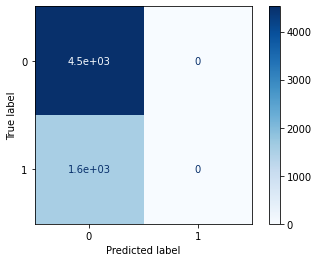

In [52]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(rf, X_test, y_test, cmap = 'Blues', )
print (classification_report(y_test, y_test_pred))

### The model is not predicting the variable 'Plumbing', because a problem of class imbalace. We can see the plumbing dataset represent 25% of the total data, causing skewing towards HEAT/HOT WATER complaints.

### One of the solution for this is balancing the dataset using the library Imblearn form sklearn. For this, we can use two options:

### First, is decreasing the Mayority Class, in this case HEAT/HOT WATER, and we call it Under-Sampling Mayority Class.

### Second, is increasing the Minority Class, in this case PLUMBING, and we call it Over-Sampling Minority Class.

### Importing Library

In [53]:
import imblearn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Random under-sampling with imblearn

This means we are going to reduce sample number on the class 0 (HEAT/HOT WATER) to balance the dataset with the class 1 (PLUMBING) in a 50/50 ratio.

In [54]:
# import library
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)

print('original dataset shape:', y.shape)
print('Resample dataset shape', y_rus.shape)

original dataset shape: (20253, 1)
Resample dataset shape (10274, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Now we re-try modeling RF with the balanced data. 

---



## Normalizing Data

In [55]:
from sklearn import preprocessing
x_rus = preprocessing.StandardScaler().fit(x_rus).transform(x_rus.astype(float))
x_rus[0:5]

array([[-0.19780213, -0.47691257, -0.68291378, -0.20489684, -0.79490019,
        -0.12329171, -0.79518126, -1.05178535],
       [ 0.67766181,  1.16102441,  1.40120732,  0.69689891,  0.69838497,
         0.20589026,  0.71439945,  0.68828812],
       [-0.19132685, -0.31311887, -0.16188351, -0.20391085, -0.73267997,
        -0.16542369,  2.49280961,  1.7447613 ],
       [-0.18777875, -0.2448715 , -0.68291378, -0.1858344 , -0.29713847,
        -0.13945381, -1.03643845, -1.05178535],
       [ 0.11698819,  0.90850913,  1.40120732,  0.09024229,  0.76060518,
        -0.05311779,  0.71439945,  0.68828812]])

### Train/Test set

Create the train/test set using a ratio of 80/20.

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_rus, y_rus, test_size = 0.2, random_state = 0)
print('Splitting ready')

Splitting ready


### Next, we are going to create a confusion matrix to visualize the accuracy of the model.

In [57]:
# Importing RF library
from sklearn.ensemble import RandomForestClassifier

#Create instance
rf = RandomForestClassifier(max_depth = 4, random_state = 42)
rf.fit(X_train, y_train)
#Predicting
y_pred = rf.predict(X_test)
print('Random Forest Model is Ready')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Model is Ready


### Now with the model ready, is time to evaluate it using metrics.
## Evaluation

we are going to create a confusion matrix to visualize the accuracy of the model.

              precision    recall  f1-score   support

           0       0.52      0.51      0.52      1012
           1       0.54      0.55      0.54      1043

    accuracy                           0.53      2055
   macro avg       0.53      0.53      0.53      2055
weighted avg       0.53      0.53      0.53      2055



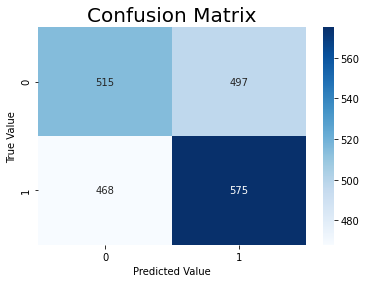

In [58]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show


print (classification_report(y_test, y_pred))

### Under-Sampling Mayority class we obtained an accuracy of the model equal to 53%, which it could be considerate moderate.

## Trying Over-Sampling with imblearn


This means we are going to increase sample number on the class 1 (PLUMBING) to balance the dataset with the class 0 (HEAT/HOT WATER) in a 50/50 ratio.

In [59]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(X, y)

print('original dataset shape:', y.shape)
print('Resample dataset shape', y_ros.shape)

original dataset shape: (20253, 1)
Resample dataset shape (30232,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [60]:
from sklearn import preprocessing
x_ros = preprocessing.StandardScaler().fit(x_ros).transform(x_ros.astype(float))
x_ros[0:5]

array([[-0.04444179,  1.16366722,  0.87931792, -0.07448016,  0.69547163,
        -0.10688399,  2.4903661 ,  1.7456706 ],
       [-0.1525514 ,  0.99970136,  0.87931792, -0.14263591,  0.20633082,
        -0.12206267,  2.4903661 ,  1.7456706 ],
       [-0.10833872,  1.00750926,  0.87931792, -0.09193362,  1.05417489,
        -0.10688399,  0.41252997, -0.42803146],
       [-0.24474445, -0.33544919, -0.68892085, -0.25634519, -0.38063816,
        -0.12388412,  0.0203556 ,  0.68987246],
       [-0.24474445, -0.3120255 , -0.68892085, -0.25634519, -0.38063816,
        -0.12631271,  0.0203556 ,  0.68987246]])

### Train/Test set

Create the train/test set using a ratio of 80/20.

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_ros, y_ros, test_size = 0.2, random_state = 0)
print('Splitting ready')

Splitting ready


In [62]:
# Importing RF library
from sklearn.ensemble import RandomForestClassifier

#Create instance
rf = RandomForestClassifier(max_depth = 4, random_state = 42)
rf.fit(X_train, y_train)
#Predicting
y_pred = rf.predict(X_test)
print('Random Forest Model is Ready')

Random Forest Model is Ready


### Now with the model ready, is time to evaluate it using metrics.
## Evaluation

we are going to create a confusion matrix to visualize the accuracy of the model.

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      3023
           1       0.54      0.53      0.54      3024

    accuracy                           0.54      6047
   macro avg       0.54      0.54      0.54      6047
weighted avg       0.54      0.54      0.54      6047



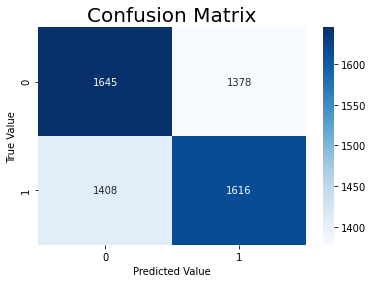

In [63]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show


print (classification_report(y_test, y_pred))

### Doing Over-Sampling Minority class we obtained an accuracy of the model equal to 54%, only 1 % more than Under-sampling, which it could be considerated moderate.

### From now on, we are going to use the Over-sample balanced data to work with the other classification models.

# Logistic Regression.

### Trying Over-Sampling with imblearn to use it in our Logistic model and avoid imbalance of the dataset.


In [68]:
# import library
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)# fit predictor and target variable
X_ros1, y_ros1 = ros.fit_resample(X, y)

print('original dataset shape:', y.shape)
print('Resample dataset shape', y_ros1.shape)

original dataset shape: (20253, 1)
Resample dataset shape (30232,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [70]:
#Normalizing the data
from sklearn import preprocessing
X_ros1 = preprocessing.StandardScaler().fit(X_ros1).transform(X_ros1)
X_ros1[0:5]

array([[-0.04444179,  1.16366722,  0.87931792, -0.07448016,  0.69547163,
        -0.10688399,  2.4903661 ,  1.7456706 ],
       [-0.1525514 ,  0.99970136,  0.87931792, -0.14263591,  0.20633082,
        -0.12206267,  2.4903661 ,  1.7456706 ],
       [-0.10833872,  1.00750926,  0.87931792, -0.09193362,  1.05417489,
        -0.10688399,  0.41252997, -0.42803146],
       [-0.24474445, -0.33544919, -0.68892085, -0.25634519, -0.38063816,
        -0.12388412,  0.0203556 ,  0.68987246],
       [-0.24474445, -0.3120255 , -0.68892085, -0.25634519, -0.38063816,
        -0.12631271,  0.0203556 ,  0.68987246]])

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_ros1, y_ros1, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (24185, 8) (24185,)
Test set: (6047, 8) (6047,)


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Create instance
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
#Predict
yhat = LR.predict(X_test)
yhat

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [73]:
#Calculate probability for all classes
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.48077472, 0.51922528],
       [0.50374046, 0.49625954],
       [0.46979158, 0.53020842],
       ...,
       [0.49473427, 0.50526573],
       [0.47930792, 0.52069208],
       [0.47002216, 0.52997784]])

## Evaluation of the model

In [74]:
from sklearn.metrics import jaccard_score
print("The Jaccard Index is:", jaccard_score(y_test, yhat,pos_label=0))

The Jaccard Index is: 0.4038583845664617


A Jaccard Index close to 1 means the similarity of the sets is high. The JI for this model is 0.40 which is not good enough.

In [75]:
#Logloss estimation
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

0.69135110053319

0.69 of logloss means the model has low probabilty to generate correct predictions.

## Confussion Matrix

<function matplotlib.pyplot.show>

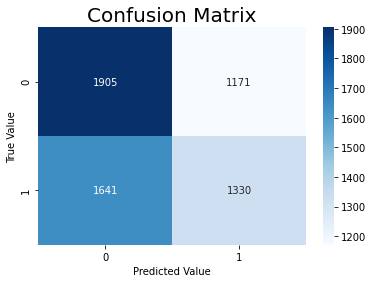

In [76]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, yhat)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show


In [77]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.54      0.62      0.58      3076
           1       0.53      0.45      0.49      2971

    accuracy                           0.53      6047
   macro avg       0.53      0.53      0.53      6047
weighted avg       0.53      0.53      0.53      6047



### Using Logistic Regression for our classification model we obtained 53% of accuracy which is moderate, but we want to make a model with a higher accuracy.

# K nearest neighbor (KNN)

## Importing Library

In [79]:
from sklearn.neighbors import KNeighborsClassifier

## Training

In [80]:
# We are assuming n_neighbors = 4
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

## Predicting

In [81]:
yhat2 = neigh.predict(X_test)
yhat2[0:5]

array([0, 0, 0, 0, 1], dtype=int64)

##Accuracy evaluation and Confusion Matrix

In multilabel classification, accuracy classification score is a function that computes subset accuracy. This function is equal to the jaccard_score function. Essentially, it calculates how closely the actual labels and predicted labels are matched in the test set.

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      3076
           1       0.66      0.63      0.64      2971

    accuracy                           0.65      6047
   macro avg       0.65      0.65      0.65      6047
weighted avg       0.65      0.65      0.65      6047



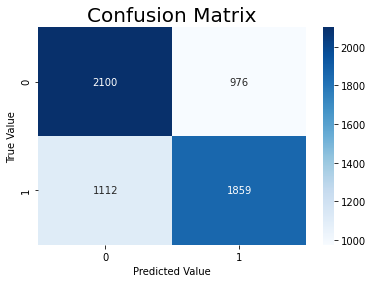

In [84]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, yhat2)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show

print (classification_report(y_test, yhat2))

### We obtaing an accuracy of 65% using KNN model to predict our classes, this is a good percentage, but we should try to improve it evaluating the model with different number of neighbors (k).

## Testing different values of k to find the optimum value.

In [86]:
Ks = 10
mean_acc = np.zeros((Ks-1)) #mean accuracy
std_acc = np.zeros((Ks-1))  #standard deviation

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat3=neigh.predict(X_test)
    #mean of the accuracy value
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat3)

    #standard deviation of the accuracy value
    std_acc[n-1]=np.std(yhat3==y_test)/np.sqrt(yhat3.shape[0])

mean_acc

array([0.77294526, 0.72085332, 0.68711758, 0.65470481, 0.62874152,
       0.62559947, 0.61352737, 0.613362  , 0.60095915])

## Visualizing results to find out what is the best value of k.

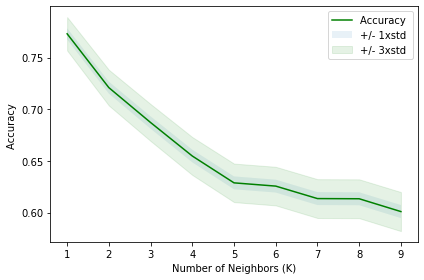

In [87]:
# Plot of K vs Accuracy
plt.plot(range(1,Ks),mean_acc,'g')
# Creating area of +/- 1 standard dev.
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
# Creating area of +/- 3 standard dev.
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

### We noticed the accuracy of our model decrese incrementing the value of k. From the plot, we notice the best value of k is 1.

##Trying KNN with k = 1 

##Modeling

In [89]:
# We are assuming n_neighbors = 4
k = 1
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
print(neigh)

# predicting
yhat4 = neigh.predict(X_test)
yhat4[0:5]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


array([0, 1, 0, 0, 1], dtype=int64)

## Evaluating

              precision    recall  f1-score   support

           0       0.84      0.69      0.75      3076
           1       0.73      0.86      0.79      2971

    accuracy                           0.77      6047
   macro avg       0.78      0.77      0.77      6047
weighted avg       0.78      0.77      0.77      6047



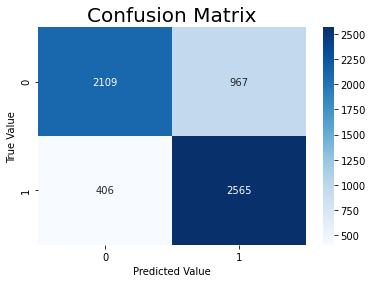

In [90]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, yhat4)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show

print (classification_report(y_test, yhat4))

### Now we notice our model accuracy improved from 65% to 77% using a k = 1, which is considered good for a prediction model.

## SVM (Support Vector Machines)

For train/test, we are going to use the same we use for KNN

## Importing Library and Modeling

In [92]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
#Fitting
clf.fit(X_train, y_train) 
## Predicting
yhat5 = clf.predict(X_test)
yhat5 [0:5]

array([1, 0, 1, 0, 1], dtype=int64)

## Evaluating

              precision    recall  f1-score   support

           0       0.54      0.56      0.55      3076
           1       0.53      0.51      0.52      2971

    accuracy                           0.53      6047
   macro avg       0.53      0.53      0.53      6047
weighted avg       0.53      0.53      0.53      6047



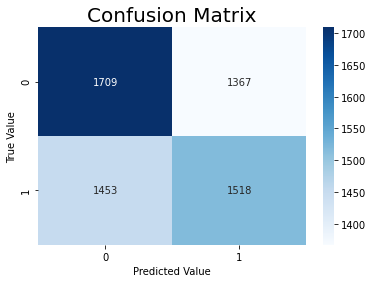

In [93]:
cf_matrix = confusion_matrix(y_test, yhat5)
sns.heatmap(cf_matrix, annot= True, fmt='', cmap='Blues') 
plt.ylabel('True Value')
plt.xlabel('Predicted Value')
plt.title('Confusion Matrix', fontsize = 20 )
plt.show

print (classification_report(y_test, yhat5))

### Using SVM with the rbf kernel, we obtained an accuracy of the model equal to 53%, same as using Random Forest algorithm.

## Evaluating different kernels of SVM
"rbf", "linear", "poly", "sigmoid"

In [96]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

#Make a for loop to find out what Kernel score the best accuracy
kerneltype = ["rbf", "linear", "poly", "sigmoid"]
for k in kerneltype:
    #Creating Instance
    clf2 = svm.SVC(kernel= k)

    #Fitting the training data
    clf2.fit(X_train, y_train)

    #Prediction
    yhat6 = clf2.predict(X_test)
    #Print Accuracy
    print("\nKernel Type: ", k)
    print("Validation set Accuracy for kernel: ", round(accuracy_score(y_test, yhat6),3))
    


Kernel Type:  rbf
Validation set Accuracy for kernel:  0.534

Kernel Type:  linear
Validation set Accuracy for kernel:  0.531

Kernel Type:  poly
Validation set Accuracy for kernel:  0.497

Kernel Type:  sigmoid
Validation set Accuracy for kernel:  0.499


### We can see the best accuracy using SVM is with the `rbf` kernel, and this is the one we used in the SVM model, so it does not worth try with the others kernel.

# Conclusion

* ## The answer for Queation 4: Can a predictive model be built for a future prediction of the possibility of complaints of the type that you have identified in response to question 1, is:

  *   ### Yes, we can build a predictive model and in this case, after trying different supervised machine learning algorithm, the best model is using **K Nearest Neighbor (KNN)**, which we obtained a model with an **accuracy equal to 77%**.

# Recommendations
## This are recommendations for continuing improving our model.

* ## One way to balance our dataset could be, adding up the 'PLUMBING' type of complaint with the rest of the minority complaints, instead randomly increase 'PLUMBING'sample data.

* ## Try combining some independent variable to see how the model improve correlation with the type of complaints.

* ## Try other classification supervised machine learning algorithms. 

## Author: 
### Hiram Mata